## Sea ice tuning for Weddell Sea convection

In [1]:
import xarray as xr
import numpy as np
import gsw
import cmocean
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import glob
import sys
sys.path.append('/home/users/birgal/')

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
nemo_mesh= f'{base_dir}bathymetry/mesh_mask-20240305.nc'

Minimum ice thickness + frazil ice: decreasing seems to improve the warm bias and the cavities somewhat (actually look at difference between ERA5_test13 and ERA5_test11

- ERA5_test10		Increase amax slightly, decrease min sea ice, increase drag, add frazil
- ERA5_test11		Increase amax, decrease min sea ice, add frazil
- ERA5_test12		Increase amax, increase drag
- ERA5_test13		Increase amax
- ERA5_test15		amax=0.95, decrease min ice, frazil
- ERA5_test16		amax=0.95, increase drag

In [6]:
test13 = xr.open_dataset(f'{base_dir}output/ERA5_test13/files/')

### Compare ERA5_test10 with ERA5_test7 or ERA5_test6

Amundsen Sea:
- ERA5_test10 has less variability in the subsurface (around 200 m) over the continental shelf and a shallower thermocline, similar surface salinity bias. Similar difference on the Getz shelf. Test10 looks worse in Pine Island Bay.
- Similar for ERA5_test11, but worse overestimate of CDW water temperature, better variability. --> Suggests that the increase in drag reduces the variability which makes some sense, so ideally don't mess with that. Could submit a test decreasing the drag?

In [3]:
from nemo_python_git.projects.evaluation import mask_obs_region, mask_sim_region
from nemo_python_git.grid import region_mask

In [3]:
def regional_profiles(run_folders, labels, region, option='shelf', fig_name=None, dpi=None, conf=None,
                      dir_obs='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/observations/pierre-dutrieux/',
                      nemo_domcfg='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/domain_cfg-20240305.nc'):

    # Get NEMO domain grid and mask for the specified region
    nemo_file = xr.open_dataset(nemo_domcfg).squeeze()
    mask, _, region_name = region_mask(region, nemo_file, option=option, return_name=True)
    # not the most elegant, but to speed up the calculations, subset x and y grid to the Amundsen Sea region. Specific to configuration/region:
    if conf=='eANT025':
        region_subsetx = slice(450,850); region_subsety = slice(140,300);
    else:
        region_subsetx = slice(0,None); region_subsety = slice(0,None);
    mask_subset = mask.isel(x=region_subsetx, y=region_subsety)

    # Find list of observations and simulation files
    # observations span 1994-2019, with mostly 2000-2019, so only take simulation files between 2000-2019 onwards
    yearly_Tobs = glob.glob(f'{dir_obs}ASEctd_griddedMean????_PT.nc')[0:2]
    yearly_Sobs = glob.glob(f'{dir_obs}ASEctd_griddedMean????_S.nc')[0:2]
    
    #----------- Figure ----------
    fig, ax = plt.subplots(1,4, figsize=(12,6), dpi=dpi, gridspec_kw={'width_ratios': [2, 1, 2, 1]})

    fig.suptitle(f'{region_name}', fontweight='bold')
    ax[0].set_ylabel('Depth (m)')
    titles = ['Conservative Temperature (C)', 'std', 'Absolute Salinity (g/kg)', 'std']
    for i, axis in enumerate(ax.ravel()):
        axis.set_ylim(1000, 0)
        if i!=0:
            axis.yaxis.set_ticklabels([])
        axis.set_title(titles[i])
        axis.xaxis.grid(True, which='major', linestyle='dotted')

    for r, run_folder in enumerate(run_folders):
        yearly_TSsim = glob.glob(f'{run_folder}*1m*20[0-1][0-9]0101*grid_T*')[0:2]

        # mean over all the years:
        sim_T, sim_S = mask_sim_region(yearly_TSsim, mask_subset, region_subsetx=region_subsetx, region_subsety=region_subsety)
        ax[0].plot(sim_T.mean(dim=['x','y','time_counter']), sim_T.deptht, '-', linewidth=2.5, label=f'Model {labels[r]}')
        ax[2].plot(sim_S.mean(dim=['x','y','time_counter']), sim_T.deptht, '-', linewidth=2.5)
        # standard deviation
        ax[1].plot(sim_T.mean(dim=['x','y']).std(dim='time_counter'), sim_T.deptht, '-')
        ax[3].plot(sim_S.mean(dim=['x','y']).std(dim='time_counter'), sim_S.deptht, '-')

    # mean over all the years 
    obs_T, obs_S = mask_obs_region(f'{dir_obs}ASEctd_griddedMean_PT.nc', f'{dir_obs}ASEctd_griddedMean_S.nc', mask, nemo_domcfg=nemo_domcfg)
    ax[0].plot(obs_T.mean(dim=['lon','lat']), abs(obs_T.depth), '--c', linewidth=2.5, label='Observations')
    ax[2].plot(obs_S.mean(dim=['lon','lat']), abs(obs_S.depth), '--c', linewidth=2.5)
    print('Calculating standard dev. obs')
    obs_T_yearly, obs_S_yearly = mask_obs_region(yearly_Tobs, yearly_Sobs, mask, nemo_domcfg=nemo_domcfg)
    ax[1].plot(obs_T_yearly.mean(dim=['lon','lat']).std(dim='year'), abs(obs_T.depth), '-c')
    ax[3].plot(obs_S_yearly.mean(dim=['lon','lat']).std(dim='year'), abs(obs_S.depth), '-c')
    
    ax[0].legend(frameon=False)

    finished_plot(fig, fig_name=fig_name, dpi=dpi)
    
    return 


In [11]:
dir13 = f'{base_dir}output/ERA5_test13/files/'
dir10 = f'{base_dir}output/ERA5_test10/files/'
dirs = [dir10, dir13]
labels = ['Test10', 'Test13']

In [ ]:
fig = regional_profiles(dirs, labels, 'amundsen_sea', option='shelf', conf='eANT025')

In [6]:
# Get NEMO domain grid and mask for the specified region
nemo_domcfg='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/domain_cfg-20240305.nc'
nemo_file  = xr.open_dataset(nemo_domcfg).squeeze()
mask, _, region_name = region_mask('amundsen_sea', nemo_file, option='shelf', return_name=True)
# not the most elegant, but to speed up the calculations, subset x and y grid to the Amundsen Sea region. Specific to configuration/region:
region_subsetx = slice(450,850); region_subsety = slice(140,300);
mask_subset = mask.isel(x=region_subsetx, y=region_subsety)

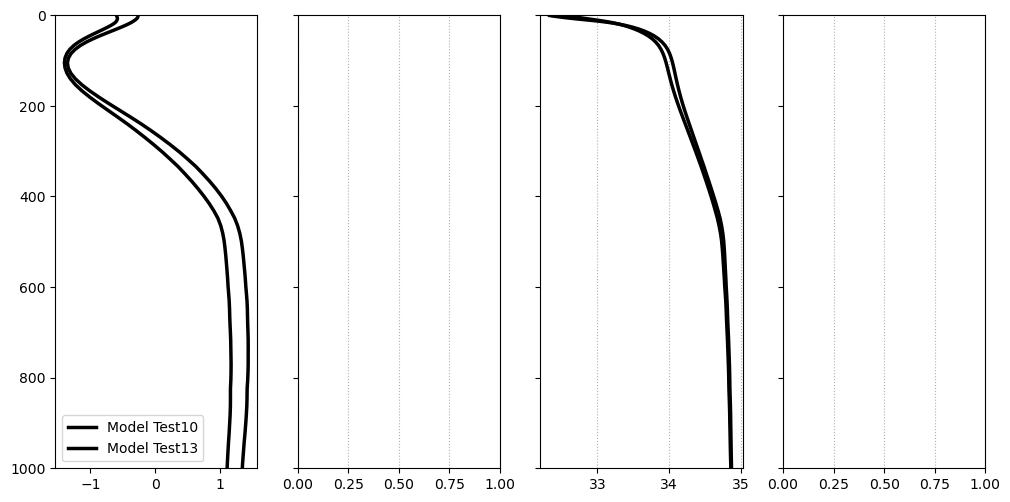

In [7]:
fig, ax = plt.subplots(1,4, figsize=(12,6), dpi=100)

for i, axis in enumerate(ax.ravel()):
    axis.set_ylim(1000, 0)
    if i!=0:
        axis.yaxis.set_ticklabels([])
        # axis.set_title(titles[i])
    axis.xaxis.grid(True, which='major', linestyle='dotted')

# for each directory, plot:
for f, folder in enumerate(dirs):
    yearly_TSsim = glob.glob(f'{folder}*1m*20[0-1][0-9]0101*grid_T*')[0:5]
    sim_T, sim_S = mask_sim_region(yearly_TSsim, mask_subset, region_subsetx=region_subsetx, region_subsety=region_subsety)
    ax[0].plot(sim_T.mean(dim=['x','y','time_counter']), sim_T.deptht, '-', linewidth=1.5, label=f'Model {labels[f]}')
    ax[2].plot(sim_S.mean(dim=['x','y','time_counter']), sim_T.deptht, '-', linewidth=1.5)

ax[0].legend()